# Age Detection
In this notebook, we will use neural networks to detect the age range of subjects using a portrait of them.

The dataset is composed of 4 folders, separating subjects by their age range :
- age 6 to 20
- 25 to 30
- 42 to 48
- 60 to 98

# Summary
- Data Analysis
- Sequential Conv2D model
- Xception Model
- ResNet50V2 model

# Library

In [39]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

# Neural networks
import tensorflow as tf
from tensorflow.keras import layers, models, activations
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

# Data

The dataset is separated into 4 folders according to their age range.

Using glob, we'll get a list of every picture's pathname.

In [15]:
PATH = "./data"

In [16]:
images_6_20 = glob.glob(PATH + "/6-20/*")
images_25_30 = glob.glob(PATH + "/25-30/*")
images_42_48 = glob.glob(PATH + "/42-48/*")
images_60_98 = glob.glob(PATH + "/60-98/*")

## Balancing the dataset

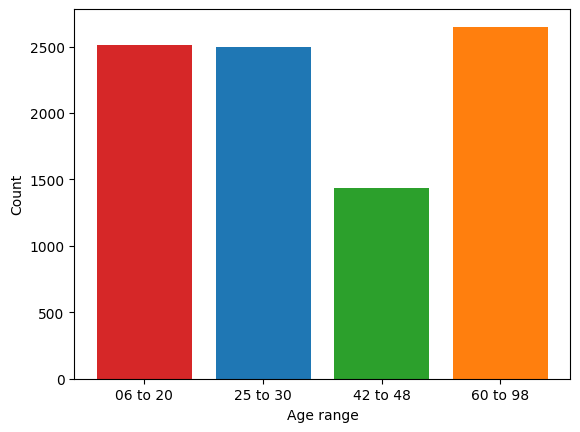

In [17]:
fig, ax = plt.subplots()
age_range = ["06 to 20", "25 to 30", "42 to 48", "60 to 98"]
counts = [len(images_6_20),len(images_25_30),len(images_42_48), len(images_60_98)]
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']
ax.set_xlabel("Age range")
ax.set_ylabel("Count")
ax.bar(age_range, counts, color = bar_colors)
plt.show()

The database is unbalanced. For a model to perform well, the training data must be balanced. We'll remove enough images from each category to get the same number of images in every age range.

In [18]:
balance = len(images_42_48)
images_6_20 = random.sample(images_6_20, balance)
images_25_30 = random.sample(images_25_30, balance)
images_60_98 = random.sample(images_60_98, balance)

# Showing a sample of the images

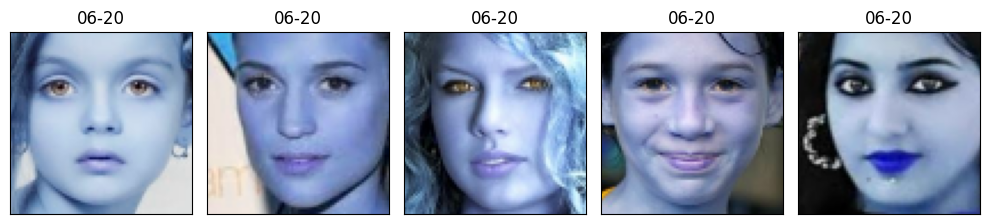

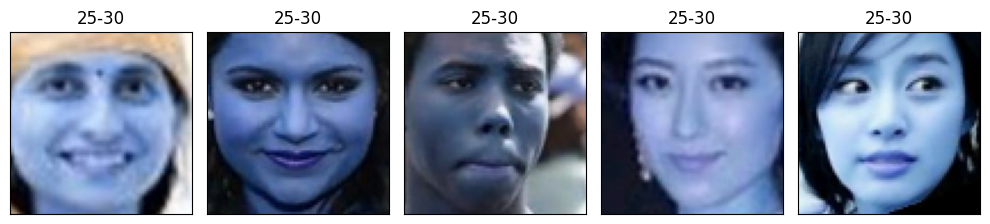

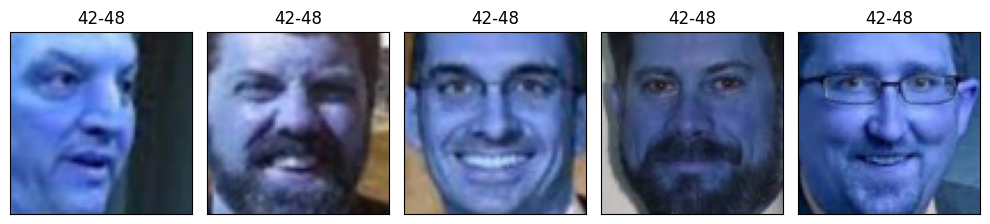

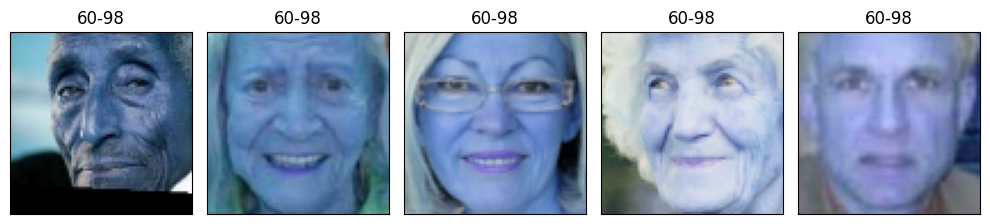

In [19]:
def show_images(list, listname):
    fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (10, 10), subplot_kw = {'xticks':[], 'yticks':[]})
    for i, ax in enumerate(axes.flat):
        img = cv2.imread(list[i])
        img = cv2.resize(img, (80, 80))
        ax.imshow(img)
        ax.set_title(listname)
    fig.tight_layout()
    plt.show()
    
show_images(images_6_20, "06-20")
show_images(images_25_30, "25-30")
show_images(images_42_48, "42-48")
show_images(images_60_98, "60-98")

# Creating an X and y for the model

In [20]:
def add_to_X_and_y(X, y, list, listname):
    for i in list:
        img = cv2.imread(i)
        scalled_raw_img = cv2.resize(img, (80, 80))/255.0
        X.append(scalled_raw_img)
        y.append(listname)
    return X, y

In [21]:
X, y = [], []

In [22]:
X, y = add_to_X_and_y(X, y, images_6_20, 0)
X, y = add_to_X_and_y(X, y, images_25_30, 1)
X, y = add_to_X_and_y(X, y, images_42_48, 2)
X, y = add_to_X_and_y(X, y, images_60_98, 3)

In [23]:
X, y = np.array(X), np.array(y)

Let's separate the target dataset into 4 categories, our age ranges, using tensorflow tools.

In [24]:
y = tf.keras.utils.to_categorical(y, num_classes=4)

In [25]:
target_name = {'6-20': 0, '25-30': 1, '42-48': 2, '60-98': 3}

Then, we'll split the data into training, validation and testing data sets.

In [26]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state = 42)

# Sequential Conv2D model

In [34]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(80, 80, 3)))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(Dense(4, activation = 'softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 78, 78, 32)        896       
                                                                 
 batch_normalization_11 (Ba  (None, 78, 78, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_10 (Activation)  (None, 78, 78, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 39, 39, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 37, 37, 64)        18496     
                                                                 
 batch_normalization_12 (Ba  (None, 37, 37, 64)       

In [35]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 256,
    epochs=30,
    validation_data = (X_val, y_val),
)

Epoch 1/30
14/14 [==============================] - 21s 1s/step - loss: 1.1611 - accuracy: 0.5265 - val_loss: 1.3664 - val_accuracy: 0.2772
Epoch 2/30
14/14 [==============================] - 17s 1s/step - loss: 0.6715 - accuracy: 0.7350 - val_loss: 1.3333 - val_accuracy: 0.3632
Epoch 3/30
14/14 [==============================] - 18s 1s/step - loss: 0.4802 - accuracy: 0.8355 - val_loss: 1.3215 - val_accuracy: 0.2850
Epoch 4/30
14/14 [==============================] - 17s 1s/step - loss: 0.3340 - accuracy: 0.9082 - val_loss: 1.4225 - val_accuracy: 0.2459
Epoch 5/30
14/14 [==============================] - 17s 1s/step - loss: 0.2126 - accuracy: 0.9615 - val_loss: 1.5858 - val_accuracy: 0.2450
Epoch 6/30
14/14 [==============================] - 18s 1s/step - loss: 0.1289 - accuracy: 0.9873 - val_loss: 1.8642 - val_accuracy: 0.2450
Epoch 7/30
14/14 [==============================] - 18s 1s/step - loss: 0.0754 - accuracy: 0.9983 - val_loss: 1.9787 - val_accuracy: 0.2450
Epoch 8/30
14/14 [==

## Predictions

In [36]:
y_pred_sequential = np.argmax(model.predict(X_test, batch_size = 1), axis = 1)
y_true = [np.argmax(y, axis = None, out = None) for y in y_test]

1152/1152 [==============================] - 5s 5ms/step


## Classification Report

In [37]:
print('Classification Report')
print(classification_report(y_true, y_pred_sequential, target_names = target_name.keys()))

Classification Report
              precision    recall  f1-score   support

        6-20       0.72      0.70      0.71       305
       25-30       0.50      0.63      0.56       270
       42-48       0.59      0.46      0.52       290
       60-98       0.72      0.72      0.72       287

    accuracy                           0.63      1152
   macro avg       0.63      0.63      0.62      1152
weighted avg       0.63      0.63      0.63      1152



## Confusion Matrix

Text(95.72222222222221, 0.5, 'Predicted')

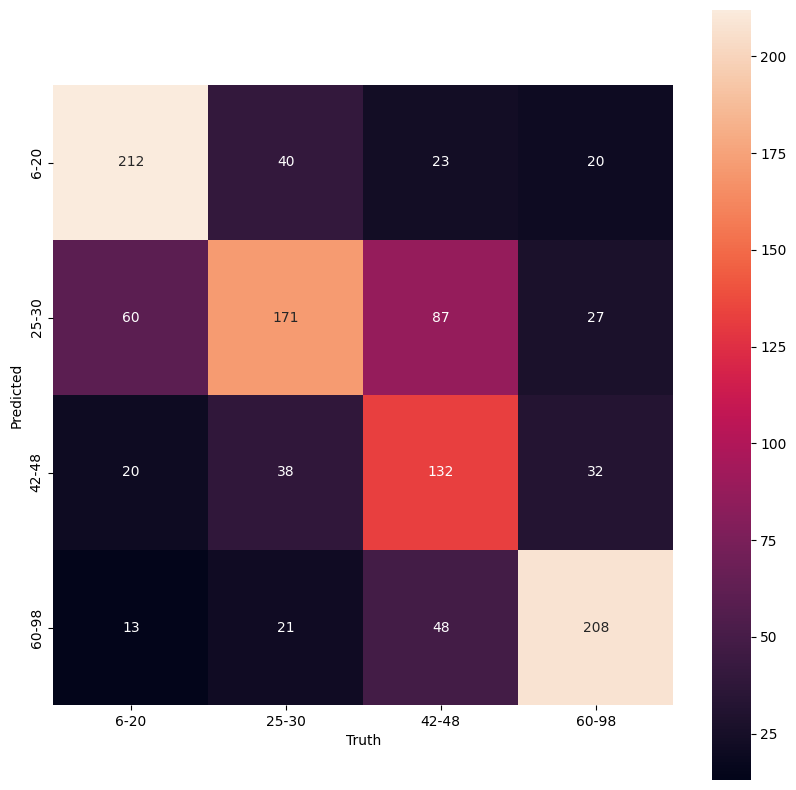

In [38]:
plt.figure(figsize=(10,10))
cm = confusion_matrix(y_true, y_pred_sequential)
_=sns.heatmap(cm.T, annot=True, fmt='d', cbar=True, square=True, xticklabels=target_name.keys(),
             yticklabels=target_name.keys())
plt.xlabel('Truth')
plt.ylabel('Predicted')

# Xception model

## Model

In [15]:
xception_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(80, 80, 3),
    pooling='avg',
    classes=4,
    classifier_activation="softmax",
)

model = Sequential()
model.add(xception_model)
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 20869676 (79.61 MB)
Trainable params: 20815148 (79.40 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 256,
    epochs = 20,
    validation_data = (X_val, y_val),
    callbacks = callback)

Epoch 1/20
14/14 [==============================] - 236s 16s/step - loss: 1.2558 - accuracy: 0.4214 - val_loss: 11.2425 - val_accuracy: 0.2285
Epoch 2/20
14/14 [==============================] - 232s 17s/step - loss: 0.6851 - accuracy: 0.7275 - val_loss: 11.3858 - val_accuracy: 0.2728
Epoch 3/20
14/14 [==============================] - 228s 16s/step - loss: 0.3814 - accuracy: 0.8480 - val_loss: 5.1703 - val_accuracy: 0.4822
Epoch 4/20
14/14 [==============================] - 230s 16s/step - loss: 0.2023 - accuracy: 0.9285 - val_loss: 7.0343 - val_accuracy: 0.4153
Epoch 5/20
14/14 [==============================] - 229s 16s/step - loss: 0.1437 - accuracy: 0.9461 - val_loss: 2.6959 - val_accuracy: 0.6620
Epoch 6/20
14/14 [==============================] - 229s 16s/step - loss: 0.1430 - accuracy: 0.9511 - val_loss: 4.9530 - val_accuracy: 0.5725
Epoch 7/20
14/14 [==============================] - 230s 16s/step - loss: 0.1082 - accuracy: 0.9595 - val_loss: 2.1994 - val_accuracy: 0.6699
Epoc

## Predictions and results

In [17]:
y_pred_xception = np.argmax(model.predict(X_test, batch_size = 1), axis = 1)
y_true = [np.argmax(y, axis = None, out = None) for y in y_test]

1152/1152 [==============================] - 38s 32ms/step


## Classification Report

In [18]:
print('Classification Report')
print(classification_report(y_true, y_pred_xception, target_names = target_name.keys()))

Classification Report
              precision    recall  f1-score   support

        6-20       0.69      0.86      0.77       305
       25-30       0.66      0.45      0.53       270
       42-48       0.67      0.57      0.61       290
       60-98       0.76      0.91      0.83       287

    accuracy                           0.70      1152
   macro avg       0.70      0.70      0.69      1152
weighted avg       0.70      0.70      0.69      1152



## Confusion Matrix

Text(95.72222222222221, 0.5, 'Predicted')

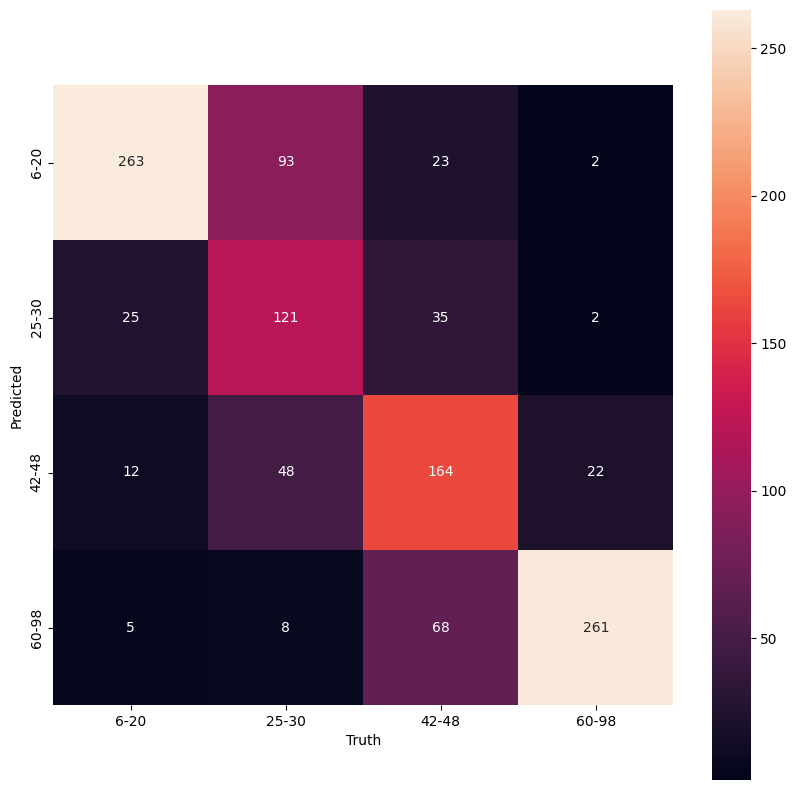

In [19]:
plt.figure(figsize=(10,10))
cm = confusion_matrix(y_true, y_pred_xception)
_=sns.heatmap(cm.T, annot=True, fmt='d', cbar=True, square=True, xticklabels=target_name.keys(),
             yticklabels=target_name.keys())
plt.xlabel('Truth')
plt.ylabel('Predicted')

# ResNet50V2 model

## Model

In [20]:
input_shape = (80, 80, 3)

resnet_model = ResNet50V2(
    weights = 'imagenet',
    input_shape = input_shape,
    classifier_activation = "softmax",
    include_top = False
)

for layer in resnet_model.layers:
    layer.trainable = True
    
model = Sequential()
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 23827588 (90.90 MB)
Trainable params: 23782148 (90.72 MB)
Non-trainable params: 45440 (177.50 KB)
________

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 256,
    epochs = 30,
    validation_data = (X_val, y_val),
    callbacks = callback)

Epoch 1/30
14/14 [==============================] - 184s 12s/step - loss: 1.0911 - accuracy: 0.5236 - val_loss: 7.9618 - val_accuracy: 0.3102
Epoch 2/30
14/14 [==============================] - 171s 12s/step - loss: 0.6357 - accuracy: 0.7437 - val_loss: 32.0488 - val_accuracy: 0.2415
Epoch 3/30
14/14 [==============================] - 171s 12s/step - loss: 0.4316 - accuracy: 0.8335 - val_loss: 6.3482 - val_accuracy: 0.3753
Epoch 4/30
14/14 [==============================] - 170s 12s/step - loss: 0.2821 - accuracy: 0.9007 - val_loss: 5.0811 - val_accuracy: 0.4700
Epoch 5/30
14/14 [==============================] - 171s 12s/step - loss: 0.2456 - accuracy: 0.9079 - val_loss: 3.1891 - val_accuracy: 0.5421
Epoch 6/30
14/14 [==============================] - 170s 12s/step - loss: 0.2087 - accuracy: 0.9241 - val_loss: 3.5600 - val_accuracy: 0.5056
Epoch 7/30
14/14 [==============================] - 171s 12s/step - loss: 0.1370 - accuracy: 0.9513 - val_loss: 3.3116 - val_accuracy: 0.6012
Epoch

## Predictions and results

In [22]:
y_pred_resnet = np.argmax(model.predict(X_test, batch_size = 1), axis = 1)
y_true = [np.argmax(y, axis = None, out = None) for y in y_test]

1152/1152 [==============================] - 25s 21ms/step


## Classification Report

In [23]:
print('Classification Report')
print(classification_report(y_true, y_pred_resnet, target_names = target_name.keys()))

Classification Report
              precision    recall  f1-score   support

        6-20       0.86      0.52      0.65       305
       25-30       0.49      0.79      0.61       270
       42-48       0.66      0.40      0.49       290
       60-98       0.70      0.88      0.78       287

    accuracy                           0.64      1152
   macro avg       0.68      0.65      0.63      1152
weighted avg       0.68      0.64      0.63      1152



## Confusion Matrix

Text(95.72222222222221, 0.5, 'Predicted')

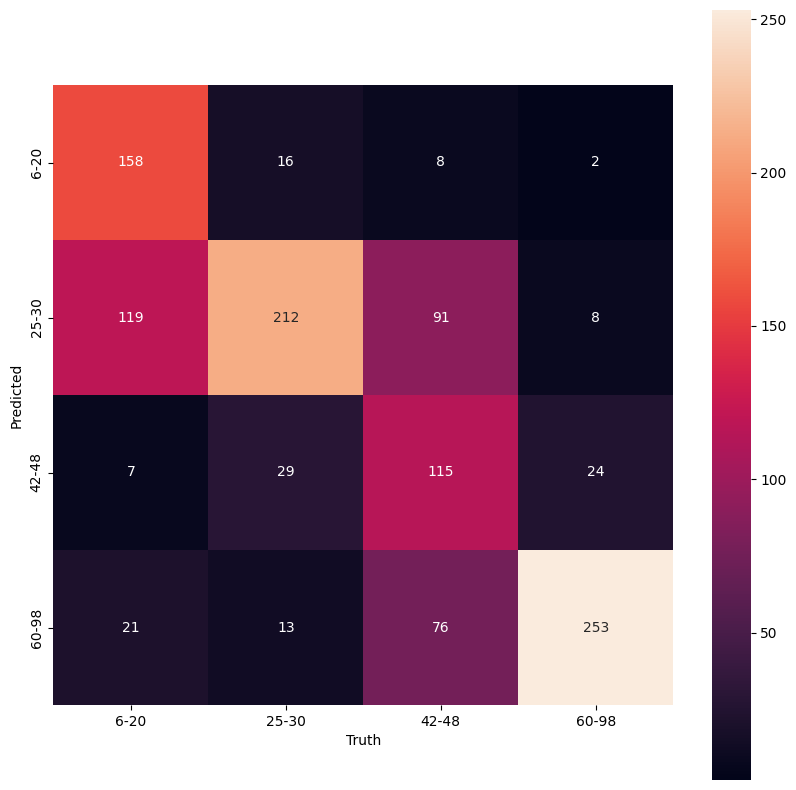

In [24]:
cm = confusion_matrix(y_true, y_pred_resnet)
plt.figure(figsize = (10,10))
_ = sns.heatmap(cm.T, annot = True, fmt = 'd', cbar = True, square = True, xticklabels = target_name.keys(),
             yticklabels = target_name.keys())
plt.xlabel('Truth')
plt.ylabel('Predicted')

# Conclusion

In conclusion, our Sequential Conv2D model performed fairly well. It suffers from very little confusion, especially compared to our other models.

On the other hand, our Xception model was extremely slow, it ran for 46 minutes. It performed fairly well, with some confusion of course.

We can see our Xception model performed much better than our ResNet50V2 model. Our ResNet50V2 model ran for 36 minutes and suffers from a lot of confusion for the age range 25-30.

Despite having balanced the dataset, we still get some confusion, probably because of the 40's age range. 

A way of fixing this could be to have images for the age range 30 - 40. This could fill the gap and help the model better distinguish the age ranges.